# Import Dependncies

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Task1: Solving A Problem using RNNs

A Recurrent Neural Network (RNN) is a neural network that can be used when your data is treated as a sequence, where the particular order of the data-points matter. For this task, I will pick a problem to solve with a time series dataset, then implement an RNN to solve it. 

The problem I will do it predicting future stock prices using RNN. I will use The Alphabet Inc stock price dataset (GOOG) and train a model on years of data, then predict the Open stock price for a certain time and see how well the RNN can model the behaviour of the stock price. 

[Dataset Source](https://finance.yahoo.com/quote/GOOG/history)

# EDA and Preprocessing

First we'll conduct some basic EDA and preprocessing steps. There's not many features to the dataset, but some of them are irrelevant. I'll also standardize the data, and decide how to split it. 

In [2]:
data = pd.read_csv("GOOG.csv", date_parser=True)

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
1,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
3,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
4,2004-08-26,2.613952,2.688672,2.606729,2.687676,2.687676,142572401


In [4]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4555,2022-09-23,100.059998,100.110001,98.010002,99.169998,99.169998,25645100
4556,2022-09-26,98.610001,100.440002,98.379997,98.809998,98.809998,22437900
4557,2022-09-27,99.910004,100.459999,97.339996,98.089996,98.089996,24225000
4558,2022-09-28,98.019997,101.400002,97.800003,100.739998,100.739998,24617000
4559,2022-09-29,99.300003,99.300003,96.519997,98.089996,98.089996,21921500


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4560 non-null   object 
 1   Open       4560 non-null   float64
 2   High       4560 non-null   float64
 3   Low        4560 non-null   float64
 4   Close      4560 non-null   float64
 5   Adj Close  4560 non-null   float64
 6   Volume     4560 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 249.5+ KB


I'll construct the training set using data from earlier than 01-01-2019. The training data will go from 08-20-2004 to 12-31-2018

In [6]:
training_set = data[data['Date']<'2019-01-01'].copy()
training_set

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
1,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
3,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
4,2004-08-26,2.613952,2.688672,2.606729,2.687676,2.687676,142572401
...,...,...,...,...,...,...,...
3611,2018-12-24,48.695000,50.176998,48.505501,48.811001,48.811001,31806000
3612,2018-12-26,49.450500,52.000000,49.150002,51.973000,51.973000,47466000
3613,2018-12-27,50.857498,52.194500,49.849998,52.194000,52.194000,42196000
3614,2018-12-28,52.480999,52.778000,51.654999,51.854000,51.854000,28296000


The testing data will be made from the remaining data points. This will be roughly an 80-20 split. 

In [7]:
testing_set = data[data['Date']>='2019-01-01'].copy()
testing_set

,Date,Open,High,Low,Close,Adj Close,Volume
3616,2019-01-02,50.828499,52.616001,50.785500,52.292500,52.292500,30652000
3617,2019-01-03,52.049999,52.848999,50.703499,50.803001,50.803001,36822000
3618,2019-01-04,51.629501,53.542000,51.370899,53.535500,53.535500,41878000
3619,2019-01-07,53.575001,53.700001,52.737999,53.419498,53.419498,39638000
3620,2019-01-08,53.805500,54.228001,53.026501,53.813999,53.813999,35298000
...,...,...,...,...,...,...,...
4555,2022-09-23,100.059998,100.110001,98.010002,99.169998,99.169998,25645100
4556,2022-09-26,98.610001,100.440002,98.379997,98.809998,98.809998,22437900
4557,2022-09-27,99.910004,100.459999,97.339996,98.089996,98.089996,24225000
4558,2022-09-28,98.019997,101.400002,97.800003,100.739998,100.739998,24617000


I will drop 2 features which will not be used for the problem. Date and Adj Close will not be used. 

In [8]:
training_set = training_set.drop(['Date', 'Adj Close'], axis=1)
training_set

,Open,High,Low,Close,Volume
0,2.515820,2.716817,2.503118,2.697639,458857488
1,2.758411,2.826406,2.716070,2.724787,366857939
2,2.770615,2.779581,2.579581,2.611960,306396159
3,2.614201,2.689918,2.587302,2.640104,184645512
4,2.613952,2.688672,2.606729,2.687676,142572401
...,...,...,...,...,...
3611,48.695000,50.176998,48.505501,48.811001,31806000
3612,49.450500,52.000000,49.150002,51.973000,47466000
3613,50.857498,52.194500,49.849998,52.194000,42196000
3614,52.480999,52.778000,51.654999,51.854000,28296000


In [9]:
testing_set = testing_set.drop(['Date', 'Adj Close'], axis=1)
testing_set

,Open,High,Low,Close,Volume
3616,50.828499,52.616001,50.785500,52.292500,30652000
3617,52.049999,52.848999,50.703499,50.803001,36822000
3618,51.629501,53.542000,51.370899,53.535500,41878000
3619,53.575001,53.700001,52.737999,53.419498,39638000
3620,53.805500,54.228001,53.026501,53.813999,35298000
...,...,...,...,...,...
4555,100.059998,100.110001,98.010002,99.169998,25645100
4556,98.610001,100.440002,98.379997,98.809998,22437900
4557,99.910004,100.459999,97.339996,98.089996,24225000
4558,98.019997,101.400002,97.800003,100.739998,24617000


Standardize the training data.

In [10]:
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
training_set

array([[7.42147420e-04, 2.98910254e-03, 6.47726513e-04, 3.39309000e-03,
        2.77885883e-01],
       [4.71387221e-03, 4.78092902e-03, 4.19771124e-03, 3.83868275e-03,
        2.22151354e-01],
       [4.91367735e-03, 4.01532048e-03, 1.92239161e-03, 1.98680072e-03,
        1.85522817e-01],
       ...,
       [7.92197069e-01, 8.11970138e-01, 7.89936866e-01, 8.15799887e-01,
        2.54669070e-02],
       [8.18777194e-01, 8.21510610e-01, 8.20026867e-01, 8.10219309e-01,
        1.70461053e-02],
       [8.19874141e-01, 8.19172467e-01, 8.12100148e-01, 8.09012903e-01,
        1.79972318e-02]])

Build the training dataset. 

I will augment the dataset by making each data point's x-value to be the 30 day history of the data. The y-value will be the 30th day's open stock price. Essentially, each day's open stock price will be associated with a 30 day history leading up to that day. 

In [11]:
x_train = []
y_train = []

for i in range(30, training_set.shape[0]):
    # append 30 day slice
    x_train.append(training_set[i-30:i])
    # append the 30th day, but only the target feature
    y_train.append(training_set[i, 0])

# turn the lists into numpy objects
x_train = np.array(x_train)
y_train = np.array(y_train)

Now we see that the x train is made of roughly 3500 data points, where each point contains a 30 history of the 5 features we have in the dataset. 

In [12]:
x_train.shape

(3586, 30, 5)

The y train is similar, except it is just a vector corresponding to the 30th day's open stock price. 

In [13]:
y_train.shape

(3586,)

Standardize the testing data

In [14]:
testing_set = scaler.fit_transform(testing_set)

I'll build the testing set in the same way as the training dataset

In [15]:
x_test = []
y_test = []
for i in range(30, testing_set.shape[0]):
    x_test.append(testing_set[i-30:i])
    y_test.append(testing_set[i, 0])

x_test = np.array(x_test)
y_test = np.array(y_test)

# Building the model - Simple RNN

First, I will use the Simple RNN from tensorflow to model this problem.

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Input

In [17]:
# use the Sequential API
model = Sequential()

# add input layer
model.add(Input(shape=(x_train.shape[1], 5)))

# add two SimpleRNN layers
model.add(SimpleRNN(128, return_sequences=True, activation='relu'))
model.add(SimpleRNN(128, activation='relu'))

# finally, add a Dense layer as output
model.add(Dense(1))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30, 128)           17152     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 50,177
Trainable params: 50,177
Non-trainable params: 0
_________________________________________________________________


Establish the optimizer and loss function for the model

In [19]:
loss = tf.keras.losses.MeanSquaredError()
optim = keras.optimizers.Adam(learning_rate=0.001)

Compile the model

In [20]:
model.compile(optimizer=optim, loss=loss)

Fit the model to the training data

In [21]:
history = model.fit(x_train, y_train, epochs=30)

Epoch 1/30
113/113 [==============================] - 2s 5ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 2/30
113/113 [==============================] - 1s 5ms/step - loss: 5.3045e-05 - mean_squared_error: 5.3045e-05
Epoch 3/30
113/113 [==============================] - 1s 5ms/step - loss: 4.7151e-05 - mean_squared_error: 4.7151e-05
Epoch 4/30
113/113 [==============================] - 1s 5ms/step - loss: 4.7687e-05 - mean_squared_error: 4.7687e-05
Epoch 5/30
113/113 [==============================] - 1s 5ms/step - loss: 4.0820e-05 - mean_squared_error: 4.0820e-05
Epoch 6/30
113/113 [==============================] - 1s 5ms/step - loss: 3.6780e-05 - mean_squared_error: 3.6780e-05
Epoch 7/30
113/113 [==============================] - 1s 5ms/step - loss: 4.3538e-05 - mean_squared_error: 4.3538e-05
Epoch 8/30
113/113 [==============================] - 1s 5ms/step - loss: 3.7444e-05 - mean_squared_error: 3.7444e-05
Epoch 9/30
113/113 [==============================] - 1s 5ms/ste

Plotting the Loss

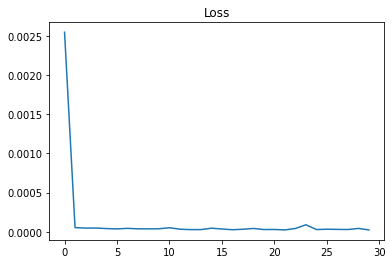

In [22]:
plt.title("Loss")
plt.plot(history.history['loss'])

Make predictions using the model

In [24]:
y_pred = model.predict(x_test)

29/29 [==============================] - 0s 2ms/step
